In [1]:
from os.path import join, basename, abspath, isfile

from hydromt_sfincs import SfincsModel
from hydromt.config import configread
from hydromt.log import setuplog
from hydromt import open_raster
import numpy as np
import yaml

## 1 Setup model simulations

In [2]:
root=r'../models/sfincs'

data_libs=[
    r'../data/sfincs_data/data_catalog.yml', 
    r'../data/sfincs_data/gtsm.yml',
    r'../models/wflow/wflow.yml' # link to wflow output data 
]

In [3]:
# configuration file
sf_config = configread('sfincs_update_forcing.yml')
print(yaml.dump(sf_config, sort_keys=False))

setup_config:
  tref: 20190312 000000
  tstart: 20190312 000000
  tstop: 20190322 000000
  dtout: 86400
setup_discharge_forcing:
  timeseries: wflow_run_era5
setup_waterlevel_forcing:
  geodataset: gtsm_idai_era5_spw
  buffer: 5000
write_forcing: null
write_config: null



In [4]:
runs = ['run_chirps', 'run_era5']#, 'run_chirps_vito', 'run_era5_vito']

for run in runs:
    sf_config['setup_discharge_forcing'].update({'timeseries': f'wflow_{run}'})
    # sf_config['setup_config'].update({'tstop': '20190314 000000'}) # short test run
    # read base model
    sf = SfincsModel(root=root, mode='r', logger=setuplog('sfincs'), data_libs=data_libs)
    sf.read()
    # create subfolder for run
    sf.set_root(join(root, run), mode='w+')
    # update paths to static files in base root
    static_maps = ['mskfile', 'indexfile', 'depfile', 'sbgfile']
    sf.config.update({k: f'../{basename(sf.config[k])}' for k in static_maps})
    # update forcing
    sf.update(opt=sf_config)

2023-11-28 14:44:07,020 - sfincs - log - INFO - HydroMT version: 0.9.1
2023-11-28 14:44:07,071 - sfincs - data_catalog - INFO - Parsing data catalog from ../data/sfincs_data/data_catalog.yml
2023-11-28 14:44:07,104 - sfincs - data_catalog - INFO - Parsing data catalog from ../data/sfincs_data/gtsm.yml
2023-11-28 14:44:07,110 - sfincs - data_catalog - INFO - Parsing data catalog from ../models/wflow/wflow.yml
2023-11-28 14:44:07,145 - sfincs - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v1.0.3.dev0).
2023-11-28 14:44:07,208 - sfincs - sfincs - WARNING - depfile not found at c:\Users\eilan_dk\project_data\hydromt-wflow-sfincs\models\sfincs\sfincs.dep
2023-11-28 14:44:07,236 - sfincs - sfincs - WARNING - depfile not found at c:\Users\eilan_dk\project_data\hydromt-wflow-sfincs\models\sfincs\sfincs.dep
2023-11-28 14:44:08,099 - sfincs - model_grid - WARNING - Replacing grid map: msk
2023-11-28 14:44:08,430 - sfincs - model_api - WARNING - Replacing geom: region
2023-11

## 2 Run model simulations

In [5]:
# this step can be skipped if you don't have the SFINCS executable
# the output is already in the repo
# this should take approx ~5 min per simulation

# uncomment to run the model
from execute import execute
from data import copyfile
import shutil

# if you don't have the SFINCS executable in the bin folder
# the model results will be downloaded from zenodo

exe = abspath(r'../bin/sfincs/sfincs.exe')

if isfile(exe):
    for run in runs:
        print(run)
        log = []
        for line in execute([exe], cwd=join(root, run), shell=True):
            # print(line, end='')
            log.append(line)
        with open(join(root, run, 'sfincs.log'), 'w') as f:
            f.writelines(log)
else:
    src = f'https://zenodo.org/record/7858596/files/sfincs_results.zip'
    dst = join("../models/sfincs/", basename(src))
    if not isfile(dst):
        copyfile(src, dst)
        shutil.unpack_archive(dst, "../models/sfincs/")

run_chirps
run_era5


## 3 Create flood depth maps from SFINCS output

In [6]:
from hydromt_sfincs import utils

# first we are going to select our highest-resolution elevation dataset
depsbg_fn = join(root, "subgrid", "dep_subgrid.tif")
da_dep = open_raster(depsbg_fn).load()
hmin = 0.05  # minimum flood depth [m] to plot

hmax_out = {}
for run in runs:
    sf = SfincsModel(join(root, run), mode="r")

    # zsmax is computed by SFINCS as the maximum water level in the domain
    da_zsmax = sf.results["zsmax"].load()

    # downscale the floodmap 
    da_hmax = utils.downscale_floodmap(
        zsmax=da_zsmax, 
        dep=da_dep, 
        hmin=hmin, 
        # floodmap_fn=join(sfincs_root, "floodmap.tif") # uncomment to save to <mod.root>/floodmap.tif
    )

    # update attributes for colorbar label later
    da_hmax.attrs.update(long_name="flood depth", unit="m")

    # 
    hmax_out[run] = da_hmax

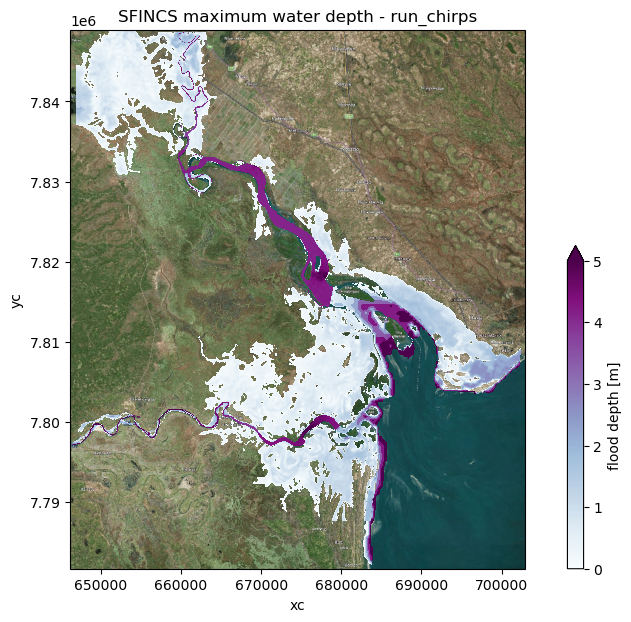

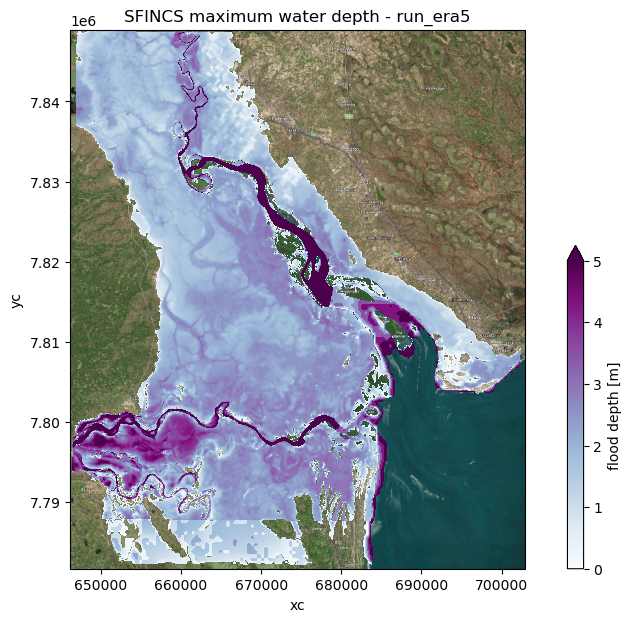

In [8]:
# create flood depth maps
for run, da_hmax in hmax_out.items():
    fig, ax = sf.plot_basemap(
        fn_out=None,
        variable="", # no variable to plot, only basemap
        plot_bounds=False, 
        plot_geoms=False,
        bmap="sat",
        zoomlevel=12,
        figsize=(11, 7),
    )

    cax_fld = da_hmax.plot(
        x="xc", y="yc",
        ax=ax,
        vmin=0, vmax=5,
        cmap="BuPu",
        cbar_kwargs={"shrink": 0.6, "anchor": (0, 0)},
    )

    _ = ax.set_title(f"SFINCS maximum water depth - {run}")
    fig.savefig(join(root, run, f"{run}_hmax.png"), dpi=300, bbox_inches="tight")
